In [96]:
import uproot
import awkward as ak # to represent nested data in columnar format
import vector 
import pyarrow as pa
import urllib.request
import numpy.ma as ma
import time 
import math 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator,AutoMinorLocator 
from lmfit.models import PolynomialModel, GaussianModel 

import infofile 


In [2]:
#The luminosity of the data
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1 # reduce this for the code to run quicker
                                                                                                                                  
tuple_path = "~/docker/tutorials/4lep/" # local 
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    'bkg_tt' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6a2d8a" 
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#d662a8" 
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#ffb495" 
    },

}

MeV = 0.001
GeV = 1.0

In [3]:
def get_data_from_files():

    data = {} # define empty dictionary to hold awkward arrays
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append array returned from read_file to list of awkward arrays
        data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    
    return data # return dictionary of awkward arrays

In [56]:
def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON 
        * events.scaleFactor_LepTRIGGER
    )

def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV


def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0


def cut_lep_type(lep_type):
    num_lep = ak.count(lep_type)
    sum_lep_type = np.sum(lep_type[:, :num_lep], axis =1)
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

In [57]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = [] # define empty list to hold all data for this sample
    
    # open the tree called mini using a context manager (will automatically close files/resources)
    with uproot.open(path + ":mini") as tree:
        numevents = tree.num_entries # number of events
        if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
        for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                                  'lep_E','lep_charge','lep_type', 
                                  # add more variables here if you make cuts on them 
                                  'mcWeight','scaleFactor_PILEUP',
                                  'scaleFactor_ELE','scaleFactor_MUON',
                                  'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                                 library="ak", # choose output type as awkward array
                                 entry_stop=numevents*fraction): # process up to numevents*fraction

            nIn = len(data) # number of events in this batch

            if 'data' not in sample: # only do this for Monte Carlo simulation files
                # multiply all Monte Carlo weights and scale factors together to give total weight
                data['totalWeight'] = calc_weight(xsec_weight, data)

            # cut on lepton charge using the function cut_lep_charge defined above
            data = data[~cut_lep_charge(data.lep_charge)]

            # cut on lepton type using the function cut_lep_type defined above
            data = data[~cut_lep_type(data.lep_type)]

            # calculation of 4-lepton invariant mass using the function calc_mllll defined above
            data['mllll'] = calc_mllll(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)

            # array contents can be printed at any stage like this
            #print(data)

            # array column can be printed at any stage like this
            #print(data['lep_pt'])

            # multiple array columns can be printed at any stage like this
            #print(data[['lep_pt','lep_eta']])

            nOut = len(data) # number of events passing cuts in this batch
            data_all.append(data) # append array from this batch
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return ak.concatenate(data_all) # return array containing events passing all cuts

In [58]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	1	 in 0.5s
		 nIn: 1,	 nOut: 	1	 in 0.6s
		 nIn: 1,	 nOut: 	0	 in 0.7s
		 nIn: 1,	 nOut: 	1	 in 0.8s
		 nIn: 1,	 nOut: 	1	 in 0.9s
		 nIn: 1,	 nOut: 	0	 in 1.1s
		 nIn: 1,	 nOut: 	1	 in 1.2s
		 nIn: 1,	 nOut: 	1	 in 1.4s
		 nIn: 1,	 nOut: 	1	 in 1.6s
		 nIn: 1,	 nOut: 	0	 in 1.8s
		 nIn: 1,	 nOut: 	0	 in 2.1s
		 nIn: 1,	 nOut: 	0	 in 2.2s
		 nIn: 1,	 nOut: 	0	 in 2.4s
		 nIn: 1,	 nOut: 	1	 in 2.5s
		 nIn: 1,	 nOut: 	1	 in 2.7s
		 nIn: 1,	 nOut: 	1	 in 2.9s
		 nIn: 1,	 nOut: 	1	 in 3.0s
		 nIn: 1,	 nOut: 	1	 in 3.1s
		 nIn: 1,	 nOut: 	1	 in 3.2s
		 nIn: 1,	 nOut: 	1	 in 3.4s
		 nIn: 1,	 nOut: 	1	 in 3.4s
		 nIn: 1,	 nOut: 	1	 in 3.6s
		 nIn: 1,	 nOut: 	1	 in 3.7s
		 nIn: 1,	 nOut: 	1	 in 3.8s
		 nIn: 1,	 nOut: 	1	 in 3.8s
		 nIn: 1,	 nOut: 	0	 in 4.0s
		 nIn: 1,	 nOut: 	1	 in 4.4s
		 nIn: 1,	 nOut: 	0	 in 4.6s
		 nIn: 1,	 nOut: 	1	 in 4.7s
		 nIn: 1,	 nOut: 	1	 in 4.9s
		 nIn: 1,	 nOut: 	0	 in 5

		 nIn: 1,	 nOut: 	0	 in 7.9s
		 nIn: 1,	 nOut: 	1	 in 8.1s
		 nIn: 1,	 nOut: 	0	 in 8.1s
		 nIn: 1,	 nOut: 	1	 in 8.2s
		 nIn: 1,	 nOut: 	1	 in 8.3s
		 nIn: 1,	 nOut: 	1	 in 8.4s
		 nIn: 1,	 nOut: 	1	 in 8.5s
		 nIn: 1,	 nOut: 	0	 in 8.6s
		 nIn: 1,	 nOut: 	0	 in 8.7s
		 nIn: 1,	 nOut: 	0	 in 8.8s
		 nIn: 1,	 nOut: 	1	 in 8.9s
		 nIn: 1,	 nOut: 	1	 in 9.0s
		 nIn: 1,	 nOut: 	1	 in 9.0s
		 nIn: 1,	 nOut: 	0	 in 9.1s
		 nIn: 1,	 nOut: 	1	 in 9.2s
		 nIn: 1,	 nOut: 	0	 in 9.3s
		 nIn: 1,	 nOut: 	0	 in 9.4s
		 nIn: 1,	 nOut: 	1	 in 9.5s
		 nIn: 1,	 nOut: 	0	 in 9.6s
		 nIn: 1,	 nOut: 	1	 in 9.7s
		 nIn: 1,	 nOut: 	1	 in 9.8s
		 nIn: 1,	 nOut: 	1	 in 9.9s
		 nIn: 1,	 nOut: 	0	 in 10.0s
		 nIn: 1,	 nOut: 	0	 in 10.1s
		 nIn: 1,	 nOut: 	0	 in 10.1s
		 nIn: 1,	 nOut: 	1	 in 10.2s
		 nIn: 1,	 nOut: 	0	 in 10.3s
		 nIn: 1,	 nOut: 	1	 in 10.4s
		 nIn: 1,	 nOut: 	0	 in 10.5s
		 nIn: 1,	 nOut: 	0	 in 10.6s
		 nIn: 1,	 nOut: 	0	 in 10.7s
		 nIn: 1,	 nOut: 	0	 in 10.8s
		 nIn: 1,	 nOut: 	1	 in 10.9s

		 nIn: 1,	 nOut: 	1	 in 11.1s
		 nIn: 1,	 nOut: 	0	 in 11.2s
		 nIn: 1,	 nOut: 	1	 in 11.2s
		 nIn: 1,	 nOut: 	0	 in 11.3s
		 nIn: 1,	 nOut: 	0	 in 11.4s
		 nIn: 1,	 nOut: 	1	 in 11.5s
		 nIn: 1,	 nOut: 	1	 in 11.6s
		 nIn: 1,	 nOut: 	1	 in 11.7s
		 nIn: 1,	 nOut: 	1	 in 11.8s
		 nIn: 1,	 nOut: 	0	 in 11.9s
		 nIn: 1,	 nOut: 	1	 in 12.0s
		 nIn: 1,	 nOut: 	0	 in 12.0s
		 nIn: 1,	 nOut: 	1	 in 12.1s
		 nIn: 1,	 nOut: 	0	 in 12.2s
		 nIn: 1,	 nOut: 	0	 in 12.3s
		 nIn: 1,	 nOut: 	1	 in 12.4s
		 nIn: 1,	 nOut: 	1	 in 12.5s
		 nIn: 1,	 nOut: 	1	 in 12.6s
		 nIn: 1,	 nOut: 	0	 in 12.6s
		 nIn: 1,	 nOut: 	1	 in 12.7s
		 nIn: 1,	 nOut: 	1	 in 12.8s
		 nIn: 1,	 nOut: 	0	 in 12.9s
		 nIn: 1,	 nOut: 	1	 in 13.0s
		 nIn: 1,	 nOut: 	1	 in 13.1s
		 nIn: 1,	 nOut: 	0	 in 13.2s
		 nIn: 1,	 nOut: 	0	 in 13.3s
		 nIn: 1,	 nOut: 	1	 in 13.3s
		 nIn: 1,	 nOut: 	1	 in 13.4s
		 nIn: 1,	 nOut: 	1	 in 13.5s
		 nIn: 1,	 nOut: 	1	 in 13.6s
		 nIn: 1,	 nOut: 	1	 in 13.7s
		 nIn: 1,	 nOut: 	1	 in 13.8s
		 nIn: 

		 nIn: 1,	 nOut: 	1	 in 36.9s
		 nIn: 1,	 nOut: 	1	 in 37.0s
		 nIn: 1,	 nOut: 	1	 in 37.1s
		 nIn: 1,	 nOut: 	1	 in 37.2s
		 nIn: 1,	 nOut: 	0	 in 37.3s
		 nIn: 1,	 nOut: 	0	 in 37.4s
		 nIn: 1,	 nOut: 	1	 in 37.5s
		 nIn: 1,	 nOut: 	1	 in 37.6s
		 nIn: 1,	 nOut: 	1	 in 37.7s
		 nIn: 1,	 nOut: 	0	 in 37.8s
		 nIn: 1,	 nOut: 	1	 in 37.9s
		 nIn: 1,	 nOut: 	0	 in 38.0s
		 nIn: 1,	 nOut: 	1	 in 38.0s
		 nIn: 1,	 nOut: 	0	 in 38.1s
		 nIn: 1,	 nOut: 	1	 in 38.2s
		 nIn: 1,	 nOut: 	1	 in 38.3s
		 nIn: 1,	 nOut: 	0	 in 38.4s
		 nIn: 1,	 nOut: 	0	 in 38.5s
		 nIn: 1,	 nOut: 	0	 in 38.7s
		 nIn: 1,	 nOut: 	0	 in 38.7s
		 nIn: 1,	 nOut: 	1	 in 38.9s
		 nIn: 1,	 nOut: 	1	 in 38.9s
		 nIn: 1,	 nOut: 	1	 in 39.0s
		 nIn: 1,	 nOut: 	0	 in 39.1s
		 nIn: 1,	 nOut: 	1	 in 39.2s
		 nIn: 1,	 nOut: 	0	 in 39.3s
Processing bkg_tt samples
	Processing: Zee
		 nIn: 1,	 nOut: 	0	 in 0.2s
		 nIn: 1,	 nOut: 	0	 in 0.3s
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	1	 in 0.5s
		 nIn: 1,	 nOut: 	0	 in 0.6s
	

		 nIn: 1,	 nOut: 	0	 in 35.6s
		 nIn: 1,	 nOut: 	0	 in 35.8s
		 nIn: 1,	 nOut: 	0	 in 36.0s
		 nIn: 1,	 nOut: 	0	 in 36.6s
		 nIn: 1,	 nOut: 	0	 in 36.8s
		 nIn: 1,	 nOut: 	0	 in 37.0s
		 nIn: 1,	 nOut: 	0	 in 37.3s
		 nIn: 1,	 nOut: 	0	 in 37.4s
		 nIn: 1,	 nOut: 	0	 in 37.5s
		 nIn: 1,	 nOut: 	0	 in 37.6s
		 nIn: 1,	 nOut: 	0	 in 38.7s
		 nIn: 1,	 nOut: 	0	 in 39.1s
		 nIn: 1,	 nOut: 	0	 in 39.3s
		 nIn: 1,	 nOut: 	1	 in 39.5s
		 nIn: 1,	 nOut: 	0	 in 39.8s
		 nIn: 1,	 nOut: 	1	 in 40.1s
		 nIn: 1,	 nOut: 	0	 in 40.2s
		 nIn: 1,	 nOut: 	0	 in 40.4s
		 nIn: 1,	 nOut: 	0	 in 40.6s
		 nIn: 1,	 nOut: 	0	 in 40.7s
		 nIn: 1,	 nOut: 	0	 in 40.8s
		 nIn: 1,	 nOut: 	0	 in 40.9s
		 nIn: 1,	 nOut: 	0	 in 41.0s
		 nIn: 1,	 nOut: 	0	 in 41.1s
		 nIn: 1,	 nOut: 	0	 in 41.2s
		 nIn: 1,	 nOut: 	0	 in 41.3s
		 nIn: 1,	 nOut: 	0	 in 41.4s
		 nIn: 1,	 nOut: 	0	 in 41.5s
		 nIn: 1,	 nOut: 	0	 in 41.6s
		 nIn: 1,	 nOut: 	0	 in 41.7s
		 nIn: 1,	 nOut: 	0	 in 41.8s
		 nIn: 1,	 nOut: 	0	 in 41.9s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 75.9s
		 nIn: 1,	 nOut: 	0	 in 76.3s
		 nIn: 1,	 nOut: 	1	 in 76.4s
		 nIn: 1,	 nOut: 	0	 in 76.7s
		 nIn: 1,	 nOut: 	0	 in 76.9s
		 nIn: 1,	 nOut: 	0	 in 77.1s
		 nIn: 1,	 nOut: 	0	 in 77.3s
		 nIn: 1,	 nOut: 	0	 in 77.4s
		 nIn: 1,	 nOut: 	1	 in 77.6s
		 nIn: 1,	 nOut: 	0	 in 77.7s
		 nIn: 1,	 nOut: 	0	 in 77.9s
		 nIn: 1,	 nOut: 	0	 in 78.1s
		 nIn: 1,	 nOut: 	1	 in 78.3s
		 nIn: 1,	 nOut: 	0	 in 78.5s
		 nIn: 1,	 nOut: 	1	 in 78.6s
		 nIn: 1,	 nOut: 	1	 in 78.8s
		 nIn: 1,	 nOut: 	1	 in 79.0s
		 nIn: 1,	 nOut: 	0	 in 79.2s
		 nIn: 1,	 nOut: 	0	 in 79.4s
		 nIn: 1,	 nOut: 	0	 in 79.5s
		 nIn: 1,	 nOut: 	1	 in 79.7s
		 nIn: 1,	 nOut: 	0	 in 79.8s
		 nIn: 1,	 nOut: 	1	 in 80.0s
		 nIn: 1,	 nOut: 	0	 in 80.4s
		 nIn: 1,	 nOut: 	1	 in 80.7s
		 nIn: 1,	 nOut: 	1	 in 80.9s
		 nIn: 1,	 nOut: 	0	 in 81.1s
		 nIn: 1,	 nOut: 	0	 in 81.3s
		 nIn: 1,	 nOut: 	0	 in 81.5s
		 nIn: 1,	 nOut: 	0	 in 81.6s
		 nIn: 1,	 nOut: 	0	 in 81.8s
		 nIn: 1,	 nOut: 	1	 in 81.9s
		 nIn: 

		 nIn: 1,	 nOut: 	1	 in 114.7s
		 nIn: 1,	 nOut: 	1	 in 114.9s
		 nIn: 1,	 nOut: 	1	 in 115.1s
		 nIn: 1,	 nOut: 	0	 in 115.2s
		 nIn: 1,	 nOut: 	0	 in 115.4s
		 nIn: 1,	 nOut: 	0	 in 115.6s
		 nIn: 1,	 nOut: 	0	 in 116.0s
		 nIn: 1,	 nOut: 	0	 in 116.2s
		 nIn: 1,	 nOut: 	1	 in 116.5s
		 nIn: 1,	 nOut: 	0	 in 116.7s
		 nIn: 1,	 nOut: 	1	 in 117.1s
		 nIn: 1,	 nOut: 	1	 in 117.3s
		 nIn: 1,	 nOut: 	0	 in 117.4s
		 nIn: 1,	 nOut: 	0	 in 117.6s
		 nIn: 1,	 nOut: 	0	 in 117.8s
		 nIn: 1,	 nOut: 	0	 in 118.1s
		 nIn: 1,	 nOut: 	0	 in 118.4s
		 nIn: 1,	 nOut: 	0	 in 118.6s
		 nIn: 1,	 nOut: 	1	 in 118.8s
		 nIn: 1,	 nOut: 	0	 in 119.0s
		 nIn: 1,	 nOut: 	0	 in 119.2s
		 nIn: 1,	 nOut: 	1	 in 119.4s
		 nIn: 1,	 nOut: 	0	 in 119.7s
		 nIn: 1,	 nOut: 	0	 in 119.8s
		 nIn: 1,	 nOut: 	0	 in 120.1s
		 nIn: 1,	 nOut: 	1	 in 120.4s
		 nIn: 1,	 nOut: 	0	 in 122.0s
		 nIn: 1,	 nOut: 	0	 in 122.2s
		 nIn: 1,	 nOut: 	0	 in 122.4s
		 nIn: 1,	 nOut: 	0	 in 122.5s
		 nIn: 1,	 nOut: 	0	 in 122.7s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 38.0s
		 nIn: 1,	 nOut: 	1	 in 38.2s
		 nIn: 1,	 nOut: 	0	 in 38.4s
		 nIn: 1,	 nOut: 	0	 in 38.5s
		 nIn: 1,	 nOut: 	0	 in 38.7s
		 nIn: 1,	 nOut: 	0	 in 38.8s
		 nIn: 1,	 nOut: 	0	 in 38.9s
		 nIn: 1,	 nOut: 	0	 in 39.2s
		 nIn: 1,	 nOut: 	1	 in 39.3s
		 nIn: 1,	 nOut: 	0	 in 39.7s
		 nIn: 1,	 nOut: 	1	 in 39.8s
		 nIn: 1,	 nOut: 	0	 in 39.9s
		 nIn: 1,	 nOut: 	0	 in 40.1s
		 nIn: 1,	 nOut: 	0	 in 40.3s
		 nIn: 1,	 nOut: 	0	 in 40.6s
		 nIn: 1,	 nOut: 	0	 in 40.8s
		 nIn: 1,	 nOut: 	0	 in 41.0s
		 nIn: 1,	 nOut: 	0	 in 41.4s
		 nIn: 1,	 nOut: 	0	 in 41.8s
		 nIn: 1,	 nOut: 	0	 in 42.1s
		 nIn: 1,	 nOut: 	1	 in 42.5s
		 nIn: 1,	 nOut: 	0	 in 42.9s
		 nIn: 1,	 nOut: 	0	 in 43.3s
		 nIn: 1,	 nOut: 	0	 in 43.6s
		 nIn: 1,	 nOut: 	0	 in 43.8s
		 nIn: 1,	 nOut: 	0	 in 44.0s
		 nIn: 1,	 nOut: 	1	 in 44.2s
		 nIn: 1,	 nOut: 	0	 in 44.4s
		 nIn: 1,	 nOut: 	0	 in 44.6s
		 nIn: 1,	 nOut: 	1	 in 44.8s
		 nIn: 1,	 nOut: 	0	 in 45.0s
		 nIn: 1,	 nOut: 	1	 in 45.2s
		 nIn: 

		 nIn: 1,	 nOut: 	1	 in 75.3s
		 nIn: 1,	 nOut: 	1	 in 75.4s
		 nIn: 1,	 nOut: 	1	 in 75.5s
		 nIn: 1,	 nOut: 	0	 in 75.6s
		 nIn: 1,	 nOut: 	1	 in 75.9s
		 nIn: 1,	 nOut: 	1	 in 76.0s
		 nIn: 1,	 nOut: 	0	 in 76.2s
		 nIn: 1,	 nOut: 	1	 in 76.3s
		 nIn: 1,	 nOut: 	0	 in 76.4s
		 nIn: 1,	 nOut: 	0	 in 76.6s
		 nIn: 1,	 nOut: 	0	 in 76.7s
		 nIn: 1,	 nOut: 	1	 in 76.8s
		 nIn: 1,	 nOut: 	0	 in 77.0s
		 nIn: 1,	 nOut: 	0	 in 77.4s
		 nIn: 1,	 nOut: 	1	 in 77.7s
		 nIn: 1,	 nOut: 	0	 in 77.9s
		 nIn: 1,	 nOut: 	1	 in 78.0s
		 nIn: 1,	 nOut: 	0	 in 78.1s
		 nIn: 1,	 nOut: 	1	 in 78.2s
		 nIn: 1,	 nOut: 	0	 in 78.4s
		 nIn: 1,	 nOut: 	0	 in 78.5s
		 nIn: 1,	 nOut: 	0	 in 78.6s
		 nIn: 1,	 nOut: 	1	 in 78.7s
		 nIn: 1,	 nOut: 	1	 in 78.8s
		 nIn: 1,	 nOut: 	0	 in 78.8s
		 nIn: 1,	 nOut: 	1	 in 78.9s
		 nIn: 1,	 nOut: 	1	 in 79.1s
		 nIn: 1,	 nOut: 	0	 in 79.2s
		 nIn: 1,	 nOut: 	0	 in 79.2s
		 nIn: 1,	 nOut: 	0	 in 79.3s
		 nIn: 1,	 nOut: 	0	 in 79.4s
		 nIn: 1,	 nOut: 	1	 in 79.5s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 115.1s
		 nIn: 1,	 nOut: 	1	 in 115.3s
		 nIn: 1,	 nOut: 	1	 in 115.6s
		 nIn: 1,	 nOut: 	1	 in 115.8s
		 nIn: 1,	 nOut: 	1	 in 116.0s
		 nIn: 1,	 nOut: 	0	 in 116.1s
		 nIn: 1,	 nOut: 	1	 in 116.3s
		 nIn: 1,	 nOut: 	1	 in 116.4s
		 nIn: 1,	 nOut: 	0	 in 116.6s
		 nIn: 1,	 nOut: 	0	 in 116.7s
		 nIn: 1,	 nOut: 	1	 in 116.9s
		 nIn: 1,	 nOut: 	0	 in 117.1s
		 nIn: 1,	 nOut: 	0	 in 117.3s
		 nIn: 1,	 nOut: 	1	 in 117.5s
		 nIn: 1,	 nOut: 	1	 in 117.7s
		 nIn: 1,	 nOut: 	0	 in 117.9s
		 nIn: 1,	 nOut: 	0	 in 118.1s
		 nIn: 1,	 nOut: 	0	 in 118.4s
		 nIn: 1,	 nOut: 	1	 in 118.6s
		 nIn: 1,	 nOut: 	0	 in 118.8s
		 nIn: 1,	 nOut: 	0	 in 119.0s
		 nIn: 1,	 nOut: 	0	 in 119.3s
		 nIn: 1,	 nOut: 	0	 in 119.5s
		 nIn: 1,	 nOut: 	1	 in 119.7s
	Processing: ttbar_lep
		 nIn: 1,	 nOut: 	0	 in 0.4s
		 nIn: 1,	 nOut: 	0	 in 0.6s
		 nIn: 1,	 nOut: 	0	 in 0.8s
		 nIn: 1,	 nOut: 	0	 in 1.0s
		 nIn: 1,	 nOut: 	0	 in 1.1s
		 nIn: 1,	 nOut: 	0	 in 1.4s
		 nIn: 1,	 nOut: 	0	 in 1.5s

		 nIn: 1,	 nOut: 	1	 in 37.0s
		 nIn: 1,	 nOut: 	0	 in 37.2s
		 nIn: 1,	 nOut: 	0	 in 37.5s
		 nIn: 1,	 nOut: 	0	 in 37.6s
		 nIn: 1,	 nOut: 	0	 in 37.7s
		 nIn: 1,	 nOut: 	0	 in 38.0s
		 nIn: 1,	 nOut: 	0	 in 38.4s
		 nIn: 1,	 nOut: 	0	 in 38.5s
		 nIn: 1,	 nOut: 	0	 in 38.9s
		 nIn: 1,	 nOut: 	1	 in 39.4s
		 nIn: 1,	 nOut: 	0	 in 39.8s
		 nIn: 1,	 nOut: 	1	 in 40.0s
		 nIn: 1,	 nOut: 	0	 in 40.1s
		 nIn: 1,	 nOut: 	0	 in 40.6s
		 nIn: 1,	 nOut: 	0	 in 41.3s
		 nIn: 1,	 nOut: 	1	 in 41.5s
		 nIn: 1,	 nOut: 	0	 in 41.6s
		 nIn: 1,	 nOut: 	0	 in 42.0s
		 nIn: 1,	 nOut: 	0	 in 42.1s
		 nIn: 1,	 nOut: 	1	 in 42.3s
		 nIn: 1,	 nOut: 	1	 in 42.9s
		 nIn: 1,	 nOut: 	0	 in 43.3s
		 nIn: 1,	 nOut: 	0	 in 43.5s
		 nIn: 1,	 nOut: 	1	 in 44.0s
		 nIn: 1,	 nOut: 	0	 in 44.2s
		 nIn: 1,	 nOut: 	0	 in 44.4s
		 nIn: 1,	 nOut: 	0	 in 44.6s
		 nIn: 1,	 nOut: 	0	 in 44.8s
		 nIn: 1,	 nOut: 	0	 in 45.1s
		 nIn: 1,	 nOut: 	0	 in 45.3s
		 nIn: 1,	 nOut: 	1	 in 45.7s
		 nIn: 1,	 nOut: 	0	 in 45.9s
		 nIn: 

		 nIn: 1,	 nOut: 	1	 in 90.1s
		 nIn: 1,	 nOut: 	1	 in 90.2s
		 nIn: 1,	 nOut: 	0	 in 90.5s
		 nIn: 1,	 nOut: 	0	 in 90.7s
		 nIn: 1,	 nOut: 	0	 in 90.9s
		 nIn: 1,	 nOut: 	0	 in 91.0s
		 nIn: 1,	 nOut: 	0	 in 91.2s
		 nIn: 1,	 nOut: 	1	 in 91.4s
		 nIn: 1,	 nOut: 	1	 in 91.5s
		 nIn: 1,	 nOut: 	0	 in 91.7s
		 nIn: 1,	 nOut: 	1	 in 91.8s
		 nIn: 1,	 nOut: 	0	 in 92.0s
		 nIn: 1,	 nOut: 	0	 in 92.1s
		 nIn: 1,	 nOut: 	0	 in 92.3s
		 nIn: 1,	 nOut: 	1	 in 92.5s
		 nIn: 1,	 nOut: 	0	 in 92.6s
		 nIn: 1,	 nOut: 	0	 in 92.9s
		 nIn: 1,	 nOut: 	0	 in 93.0s
		 nIn: 1,	 nOut: 	0	 in 93.1s
		 nIn: 1,	 nOut: 	1	 in 93.2s
		 nIn: 1,	 nOut: 	1	 in 93.4s
		 nIn: 1,	 nOut: 	0	 in 93.5s
		 nIn: 1,	 nOut: 	0	 in 93.6s
		 nIn: 1,	 nOut: 	0	 in 93.7s
		 nIn: 1,	 nOut: 	0	 in 93.9s
		 nIn: 1,	 nOut: 	0	 in 94.1s
		 nIn: 1,	 nOut: 	0	 in 94.4s
		 nIn: 1,	 nOut: 	0	 in 94.6s
		 nIn: 1,	 nOut: 	0	 in 94.8s
		 nIn: 1,	 nOut: 	0	 in 95.0s
		 nIn: 1,	 nOut: 	0	 in 95.3s
		 nIn: 1,	 nOut: 	0	 in 95.4s
		 nIn: 

		 nIn: 1,	 nOut: 	0	 in 141.2s
		 nIn: 1,	 nOut: 	0	 in 141.3s
		 nIn: 1,	 nOut: 	0	 in 141.4s
		 nIn: 1,	 nOut: 	0	 in 141.5s
		 nIn: 1,	 nOut: 	1	 in 141.6s
		 nIn: 1,	 nOut: 	0	 in 141.8s
		 nIn: 1,	 nOut: 	1	 in 141.9s
		 nIn: 1,	 nOut: 	0	 in 142.1s
		 nIn: 1,	 nOut: 	0	 in 142.2s
		 nIn: 1,	 nOut: 	0	 in 142.3s
		 nIn: 1,	 nOut: 	0	 in 142.4s
		 nIn: 1,	 nOut: 	0	 in 142.6s
		 nIn: 1,	 nOut: 	1	 in 142.8s
		 nIn: 1,	 nOut: 	0	 in 143.0s
		 nIn: 1,	 nOut: 	1	 in 143.2s
		 nIn: 1,	 nOut: 	0	 in 143.3s
		 nIn: 1,	 nOut: 	0	 in 143.4s
		 nIn: 1,	 nOut: 	0	 in 143.5s
		 nIn: 1,	 nOut: 	0	 in 143.7s
		 nIn: 1,	 nOut: 	0	 in 143.8s
		 nIn: 1,	 nOut: 	1	 in 144.0s
		 nIn: 1,	 nOut: 	0	 in 144.1s
		 nIn: 1,	 nOut: 	1	 in 144.2s
		 nIn: 1,	 nOut: 	0	 in 144.3s
		 nIn: 1,	 nOut: 	1	 in 144.4s
		 nIn: 1,	 nOut: 	1	 in 144.5s
		 nIn: 1,	 nOut: 	0	 in 144.6s
		 nIn: 1,	 nOut: 	1	 in 144.9s
		 nIn: 1,	 nOut: 	1	 in 145.0s
		 nIn: 1,	 nOut: 	1	 in 145.2s
		 nIn: 1,	 nOut: 	0	 in 145.6s
		 nIn: 

		 nIn: 1,	 nOut: 	1	 in 190.7s
		 nIn: 1,	 nOut: 	0	 in 190.9s
		 nIn: 1,	 nOut: 	0	 in 191.2s
		 nIn: 1,	 nOut: 	1	 in 191.5s
		 nIn: 1,	 nOut: 	1	 in 191.8s
		 nIn: 1,	 nOut: 	0	 in 192.1s
		 nIn: 1,	 nOut: 	0	 in 192.3s
Processing Background $ZZ^*$ samples
	Processing: llll
		 nIn: 554279,	 nOut: 	520982	 in 4.9s
Processing Signal ($m_H$ = 125 GeV) samples
	Processing: ggH125_ZZ4lep
		 nIn: 164716,	 nOut: 	160824	 in 1.5s
	Processing: VBFH125_ZZ4lep
		 nIn: 191126,	 nOut: 	186092	 in 3.6s
	Processing: WH125_ZZ4lep
		 nIn: 15379,	 nOut: 	9060	 in 0.7s
	Processing: ZH125_ZZ4lep
		 nIn: 14485,	 nOut: 	10788	 in 0.3s
Time taken: 559.8s


In [60]:
eta = pd.DataFrame(ak.to_numpy(ak.mean((data[r'Background $ZZ^*$']['lep_eta']),axis = 1)))
eta

,0
0,1.439579
1,-1.547724
2,0.014952
3,-0.083622
4,-0.374256
...,...
520977,-1.027056
520978,-0.296484
520979,-1.807209
520980,0.474908


In [121]:
desired_length = np.max(ak.num((data[r'Background $ZZ^*$']['lep_phi'])))
new_phi = ak.pad_none(data[r'Background $ZZ^*$']['lep_phi'], desired_length)
phi = (ak.to_numpy(new_phi))
ma.set_fill_value(phi, 0)
phi_new = (phi.filled())
(phi_new.flatten())

array([ 1.9609993, -2.4778569, -0.3330752, ..., -2.6386578,  0.       ,
        0.       ], dtype=float32)

In [61]:
df = ak.to_dataframe(data)
df

data                                                \
                       lep_pt   lep_eta   lep_phi          lep_E lep_charge   
entry subentry                                                                
0     0         175558.734375  2.076854  1.292963  711421.062500         -1   
      1         138846.671875  0.964199 -2.256139  208545.921875          1   
      2         106696.531250  0.453812 -1.797010  117873.273438         -1   
      3          79776.726562  2.398578  0.587067  442695.562500          1   
1     0          65284.066406  0.103152  2.329535   65631.695312         -1   
...                       ...       ...       ...            ...        ...   
504   3          26180.353516  1.285183 -1.999637   50946.031250         -1   
505   0          88545.625000 -0.845567 -0.930286  122131.515625          1   
      1          50751.835938  0.115409  1.808202   51090.308594          1   
      2          25529.919922  2.211767  0.654854  117965.445312         -1   
      3          22951.449219 -0.205597  1.450882   23438.242188         -1   

                                                                     \
               lep_type mcWeight scaleFactor_PILEUP scaleFactor_ELE   
entry subentry                                                        
0     0              11      0.0                0.0             0.0   
      1              13      0.0                0.0             0.0   
      2              13      0.0                0.0             0.0   
      3              11      0.0                0.0             0.0   
1     0              11      0.0                0.0             0.0   
...                 ...      ...                ...             ...   
504   3              11      0.0                0.0             0.0   
505   0              11      0.0                0.0             0.0   
      1              13      0.0                0.0             0.0   
      2              13      0.0                0.0             0.0   
      3              11      0.0                0.0             0.0   

                                 ... Signal ($m_H$ = 125 GeV)             \
               scaleFactor_MUON  ...                    lep_E lep_charge   
entry subentry                   ...                                       
0     0                     0.0  ...             75779.648438          1   
      1                     0.0  ...             56050.976562         -1   
      2                     0.0  ...             18376.378906          1   
      3                     0.0  ...              7739.273438         -1   
1     0                     0.0  ...             77133.531250         -1   
...                         ...  ...                      ...        ...   
504   3                     0.0  ...              9187.022461         -1   
505   0                     0.0  ...             50136.214844          1   
      1                     0.0  ...             54086.554688         -1   
      2                     0.0  ...             15527.268555          1   
      3                     0.0  ...             19098.312500         -1   

                                                                       \
               lep_type   mcWeight scaleFactor_PILEUP scaleFactor_ELE   
entry subentry                                                          
0     0              13  28.485731           0.351687        1.000000   
      1              13  28.485731           0.351687        1.000000   
      2              13  28.485731           0.351687        1.000000   
      3              13  28.485731           0.351687        1.000000   
1     0              13  28.485731           0.553627        1.000000   
...                 ...        ...                ...             ...   
504   3              13  28.485731           1.264594        0.932324   
505   0              11  28.485731           1.225855        0.936885   
      1              11  28.485731           1.225855  

In [62]:
print("hi")

hi


In [63]:
for col in df.columns:
    print(col)

('data', 'lep_pt')
('data', 'lep_eta')
('data', 'lep_phi')
('data', 'lep_E')
('data', 'lep_charge')
('data', 'lep_type')
('data', 'mcWeight')
('data', 'scaleFactor_PILEUP')
('data', 'scaleFactor_ELE')
('data', 'scaleFactor_MUON')
('data', 'scaleFactor_LepTRIGGER')
('data', 'mllll')
('bkg_tt', 'lep_pt')
('bkg_tt', 'lep_eta')
('bkg_tt', 'lep_phi')
('bkg_tt', 'lep_E')
('bkg_tt', 'lep_charge')
('bkg_tt', 'lep_type')
('bkg_tt', 'mcWeight')
('bkg_tt', 'scaleFactor_PILEUP')
('bkg_tt', 'scaleFactor_ELE')
('bkg_tt', 'scaleFactor_MUON')
('bkg_tt', 'scaleFactor_LepTRIGGER')
('bkg_tt', 'totalWeight')
('bkg_tt', 'mllll')
('Background $ZZ^*$', 'lep_pt')
('Background $ZZ^*$', 'lep_eta')
('Background $ZZ^*$', 'lep_phi')
('Background $ZZ^*$', 'lep_E')
('Background $ZZ^*$', 'lep_charge')
('Background $ZZ^*$', 'lep_type')
('Background $ZZ^*$', 'mcWeight')
('Background $ZZ^*$', 'scaleFactor_PILEUP')
('Background $ZZ^*$', 'scaleFactor_ELE')
('Background $ZZ^*$', 'scaleFactor_MUON')
('Background $ZZ^*$', 's

In [203]:
def plot_data(data):

    xmin = 50000 * GeV
    xmax = 350000
    step_size = 7000 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x = (ak.to_numpy(ak.sum((data[r'Signal ($m_H$ = 125 GeV)']['lep_pt']), axis =1))) # histogram the signal
    signal_weights = (ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append(((ak.to_numpy(ak.sum((data[s]['lep_pt']), axis =1))))) # append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    

    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights= (mc_weights), 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights= signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Background Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both',direction='in',top=True, right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=50)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05,0.93, 'ATLAS Open Data', transform=main_axes.transAxes,fontsize=13 ) 
    
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, 0.82, '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 0.76,  r'$H \rightarrow ZZ^* \rightarrow 4\ell$', transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

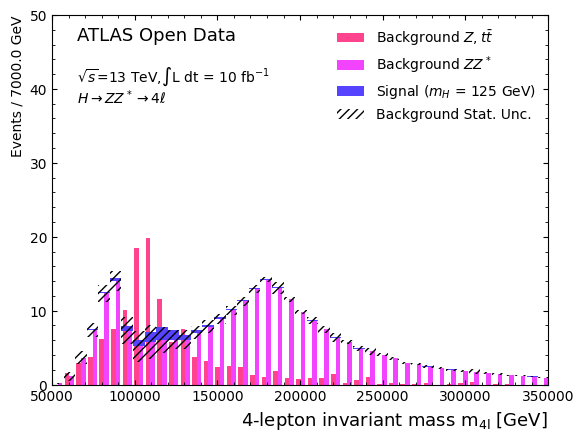

In [14]:
plot_data(data)

In [ ]:
plot_data_3(data)

In [97]:
def plot_data_4(data):

    xmin = 10000 * GeV
    xmax = 150000
    step_size = 1000 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram((ak.to_numpy(ak.mean((data['data']['lep_pt']),axis = 1))), bins=bin_edges) 
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = (ak.to_numpy(ak.mean((data[r'Signal ($m_H$ = 125 GeV)']['lep_pt']), axis =1))) # histogram the signal
    signal_weights = (ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight)) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append(((ak.to_numpy(ak.mean((data[s]['lep_pt']), axis =1))))) # append to the list of Monte Carlo histogram entries
            mc_weights.append(ak.to_numpy(data[s].totalWeight)) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=60 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    imp = (mc_x_tot)
    return imp

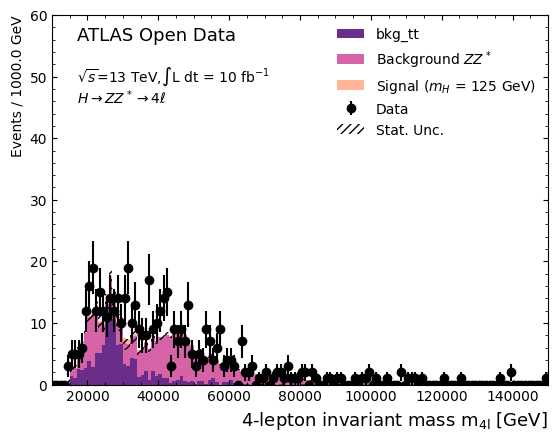

In [98]:
imp = plot_data_4(data)

In [99]:
def plot_data_5(data):

    xmin = -4 * GeV
    xmax = 4
    step_size = 0.1 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
#################
    d_length = (np.max(ak.num(data['data']['lep_phi'])))
    d_length2 = (np.max(ak.num(data[r'Signal ($m_H$ = 125 GeV)']['lep_phi'])))
    d_length3 = (np.max(ak.num(data[r'Background $ZZ^*$']['lep_phi'])))
    d_length4 = (np.max(ak.num(data['bkg_tt']['lep_phi'])))
    
################# 
    
    data_x,_ = np.histogram(ak.to_numpy(data['data']['lep_phi']), 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)']['lep_phi']) # histogram the signal
    signal_weights = ak.to_numpy(data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar


    bkg1_x = ak.to_numpy(data[r'Background $ZZ^*$']['lep_phi'])
    bkg1_weights = ak.to_numpy(data[r'Background $ZZ^*$'].totalWeight)
    bkg1_color = samples[r'Background $ZZ^*$']['color'] # get the colour for the signal bar
#.......................
    bkg2_x = ak.to_numpy(data['bkg_tt']['lep_phi'])
    bkg2__weights = ((ak.to_numpy(data['bkg_tt'].totalWeight))*4
    bkg2_weights = [bkg2__weights,bkg2__weights,bkg2__weights,bkg2__weights]
    bkg2_color = samples['bkg_tt']['color'] # get the colour for the signal bar
#..........................
    print(bkg2_x.shape,
          bkg2_weights.shape )


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    bkg1_heights = main_axes.hist(bkg1_x, bins=bin_edges, 
                                weights=bkg1_weights,
                                stacked=False,  
                                color=samples[r'Background $ZZ^*$']['color'], label=r'Background $ZZ^*$')
    bkg2_heights = main_axes.hist(bkg2_x, bins=bin_edges, 
                                weights=bkg2_weights,
                                stacked=False,  
                                color=samples['bkg_tt']['color'], label='bkg_tt' )
    
    
    mc1_x_err = np.sqrt(np.histogram(np.hstack(bkg1_x), bins=bin_edges, weights=np.hstack(bkg1_weights)**2)[0])
    mc2_x_err = np.sqrt(np.histogram(np.hstack(bkg2_x), bins=bin_edges, weights=np.hstack(bkg2_weights)**2)[0])
    main_axes.bar(bin_centres, # x
                  2*mc1_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=0, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )
    main_axes.bar(bin_centres, # x
                  
                  2*mc2_x_err, # heights
                  alpha=0.5, # half transparency
                  #bottom=mc_x_tot-mc2_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges,weights=signal_weights,stacked=False, color=signal_color,label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=60 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

SyntaxError: '(' was never closed (3875621261.py, line 35)

In [ ]:
plot_data_5(data)

In [100]:
def plot_data_variable(variable, mini,maxi, step):

    xmin = mini * GeV
    xmax = maxi
    step_size = step * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram((df['data'][variable]).to_numpy(), bins=bin_edges) 
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = (df[r'Signal ($m_H$ = 125 GeV)'][variable]).to_numpy() # histogram the signal
    signal_weights = (df[r'Signal ($m_H$ = 125 GeV)']['totalWeight']).to_numpy() # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append((df[s][variable]).to_numpy()) # append to the list of Monte Carlo histogram entries
            mc_weights.append((df[s]['totalWeight']).to_numpy())# append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels

    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges,#weights =mc_weights, 
                                 stacked=False, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1]
     # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges,weights = signal_weights, 
                   bottom=mc_x_tot, 
                   color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(variable,
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             '', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    print(mc_heights[0])
    
    return

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 11.
   8. 13. 18. 19. 11. 13. 10. 10. 16.  9. 15. 23. 10. 12. 18. 18. 19. 15.
  16. 12. 10. 21.  9. 16. 16. 12. 10. 13. 11. 13. 17. 17.  8. 80. 16. 16.
  13. 15. 11. 12. 16. 13. 21. 14. 27. 17.  9. 11. 11.  8. 13.  6.  8. 14.
  19. 13. 19. 12.  5. 17. 11. 69. 11. 13. 15. 21. 20. 17. 13. 13. 77. 12.
  16. 18. 17. 19. 15. 11. 17. 17. 13. 25. 13. 15. 10.  7. 10. 15. 11. 19.
  13. 10.  9. 10. 12. 16. 11. 14. 22. 10. 15. 21. 18. 18. 17. 20. 16. 22.
  11. 12. 11. 12. 18. 16. 16. 66. 10. 16. 14. 14. 15. 17. 17. 11.  9.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.
  10. 14. 14. 25. 15. 13. 16. 17. 10. 15. 13. 16. 20. 17. 15. 15. 14. 11.
  21. 20. 18. 11. 18. 19. 21. 16. 15. 14. 19. 18. 17. 14. 15. 14. 20. 20.
  15. 18. 10. 21. 21. 11. 14. 13. 16. 16. 15. 20. 17. 15. 15. 25. 11. 13.
  12. 14. 12. 22.  9. 11. 15. 11. 16. 18. 22.

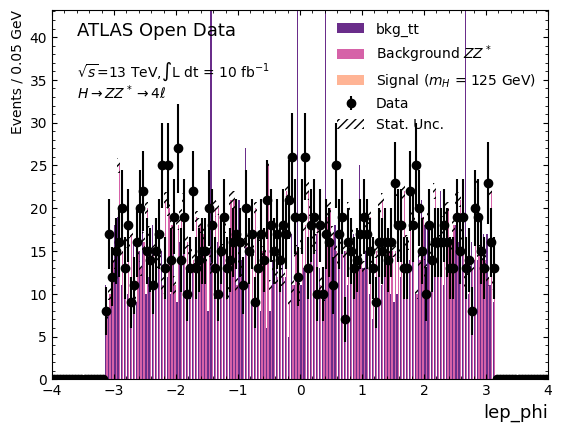

In [101]:
plot_data_variable('lep_phi', (-4), (4),(0.05))